# 1.1) Source Code - LGBMRegressor

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### 데이터 준비

In [2]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
# 데이터 살펴보기
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [4]:
# 데이터 살펴보기
test.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

***

### 데이터 전처리

In [5]:
# train data 의 결측값 확인
msno.matrix(train)

<AxesSubplot:>

<AxesSubplot:>

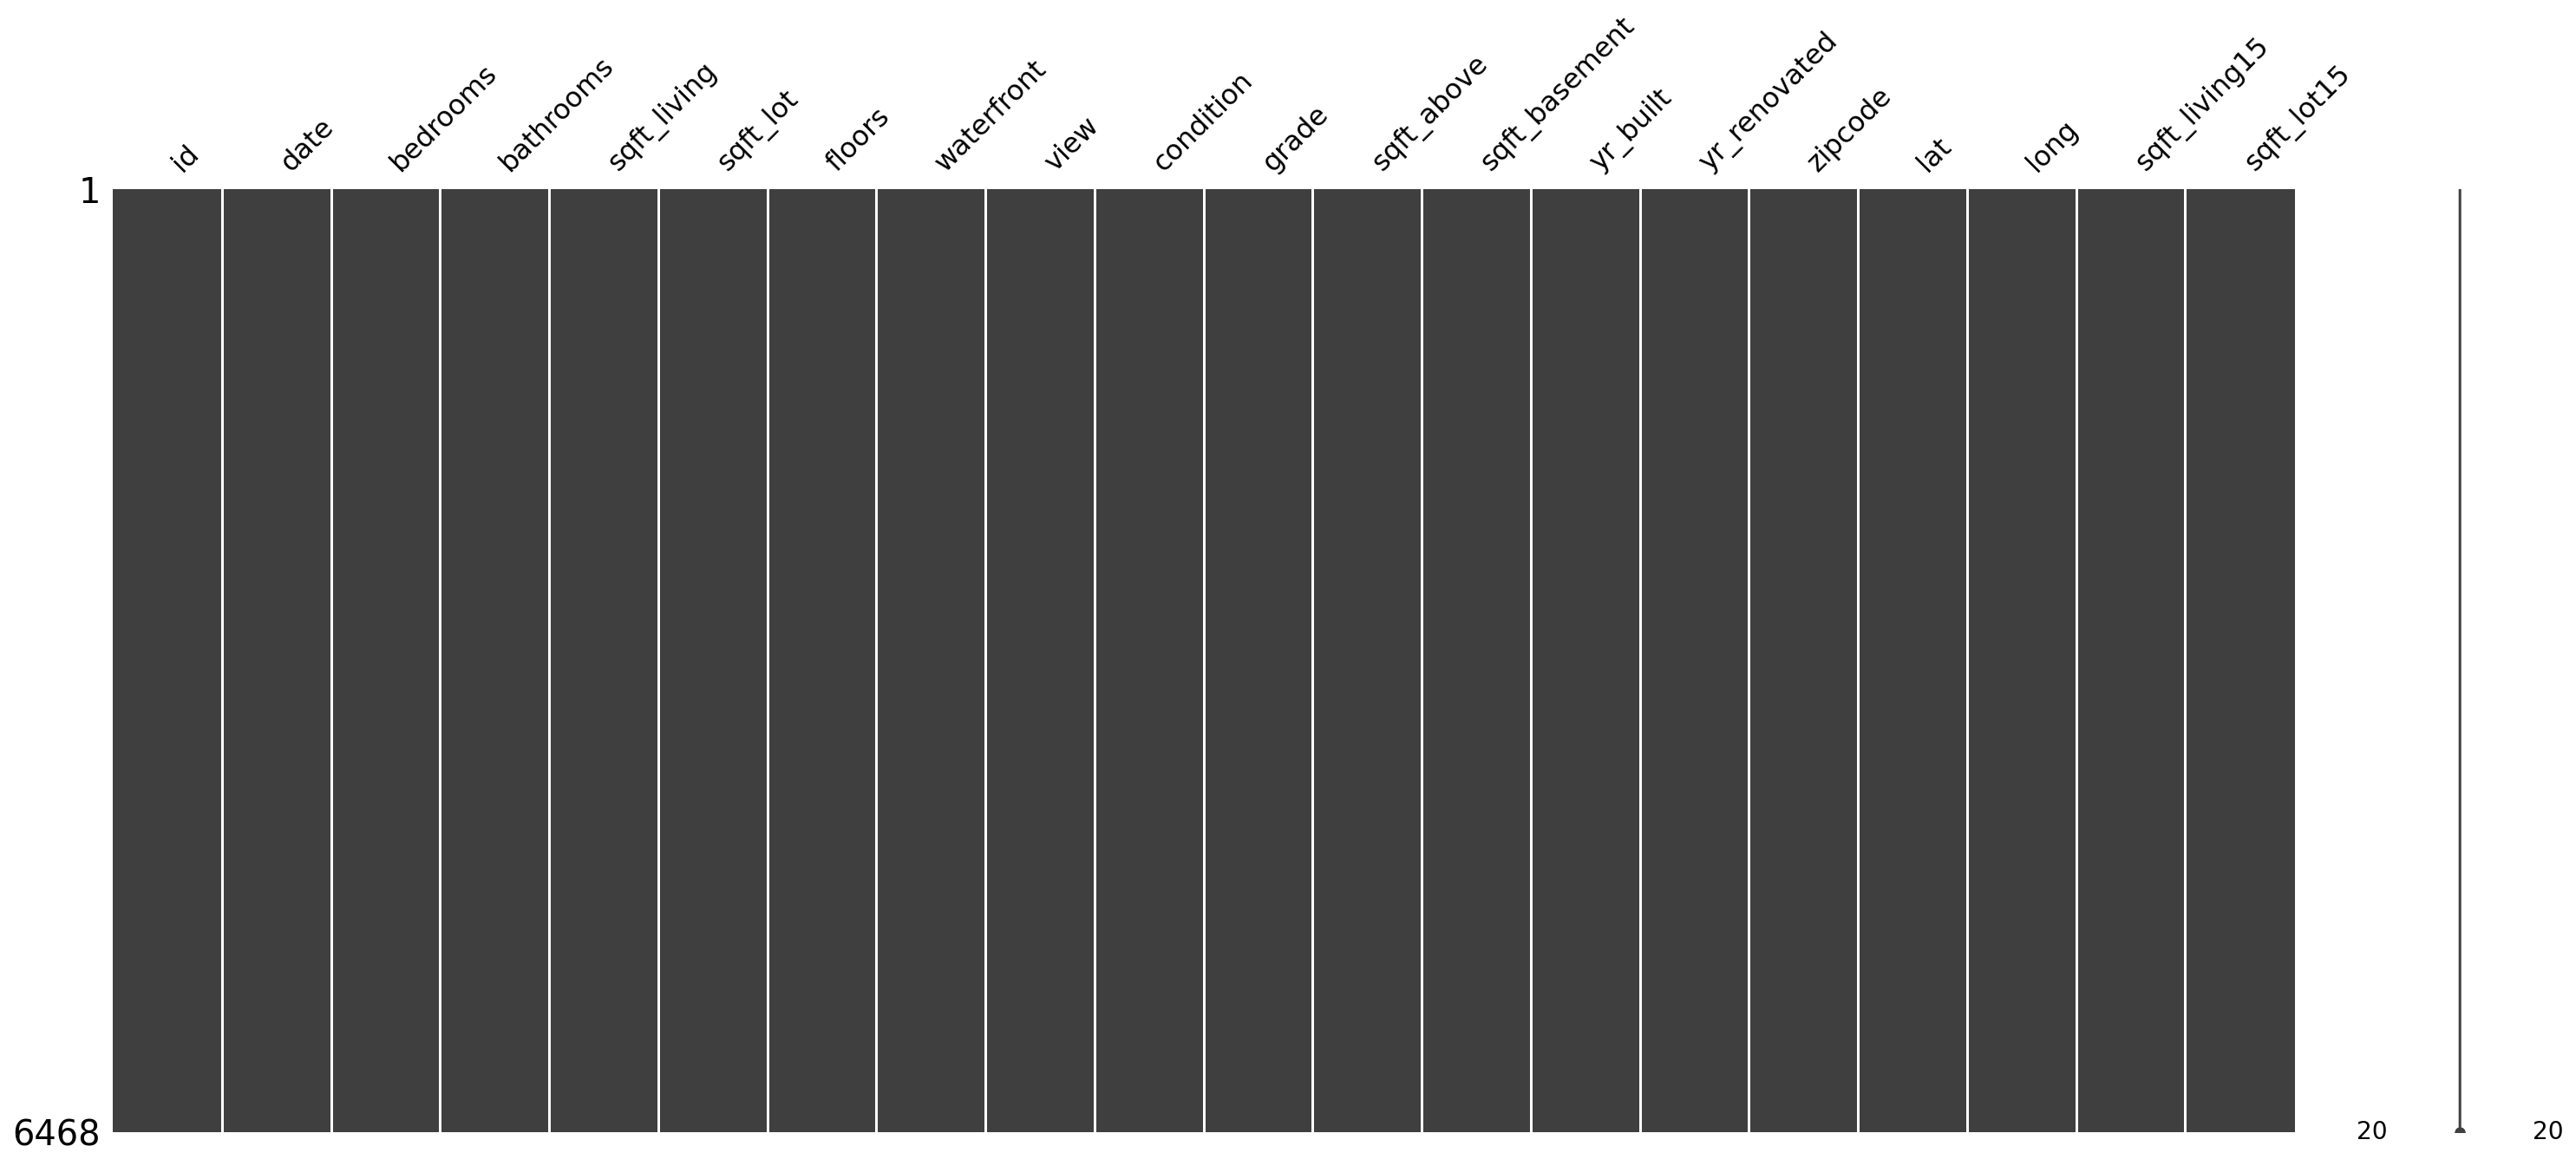

In [6]:
# test data 의 결측값 확인
msno.matrix(test)

- msno.matrix() 를 활용하여 각 데이터의 결측값을 확인해보았습니다.

In [7]:
# train data 의 결측값 확인_2
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [8]:
# test data 의 결측값 확인_2
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


- 위와 같은 방법으로도 각 데이터의 결측치를 확인할 수 있습니다.

In [9]:
# target data 에 해당하는 y 를 선언
y = train['price']
# train data 에서 price 컬럼 삭제
del train['price']

# Test
print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- price 컬럼은 예측할 데이터이므로, y 에 따로 담아줍니다.
- 그 후, train data 에서는 price 컬럼을 삭제해주었습니다.

In [10]:
train['date'] = train['date'].apply(lambda x: x[:6]).astype(int)
train.head()

id    date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   0  201410         3       1.00         1180      5650     1.0           0   
1   1  201502         2       1.00          770     10000     1.0           0   
2   2  201502         3       2.00         1680      8080     1.0           0   
3   3  201406         3       2.25         1715      6819     2.0           0   
4   4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

- date 컬럼을 연도와 월로 자르고, 학습에 사용하기 위해 int 형으로 변환해주었습니다.

In [11]:
del train['id']

# Test
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- id 컬럼은 각 데이터를 구분하는 고유번호이므로, 예측값과는 무관하여 삭제해주었습니다.

In [12]:
test['date'] = test['date'].apply(lambda x: x[:6]).astype(int)

del test['id']

# Test
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- test data 또한, date 컬럼을 동일하게 전처리해주고, id 컬럼을 삭제해주었습니다.
- test data 에는 price 컬럼이 담겨있지 않습니다.

In [13]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

- y 데이터를 살펴보겠습니다.

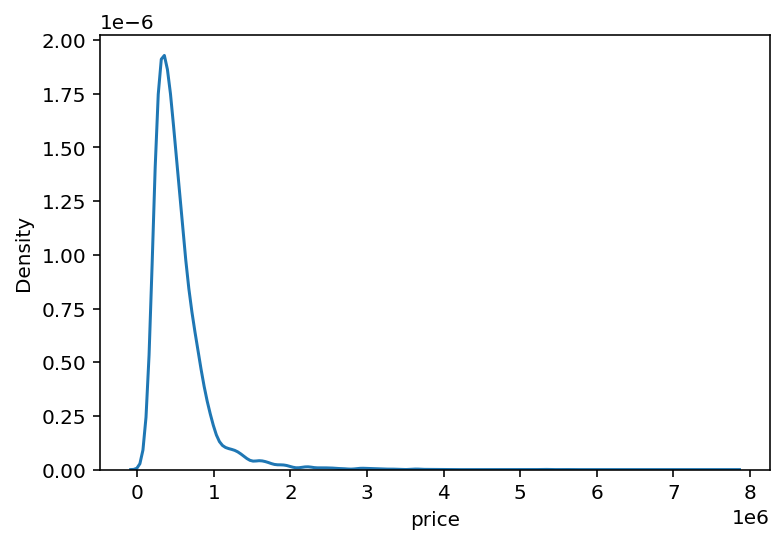

In [14]:
# y data 분포 확인
sns.kdeplot(data=y)
plt.show()

- y 데이터의 분포가 고르지 못한 것을 직관적으로 확인할 수 있습니다.

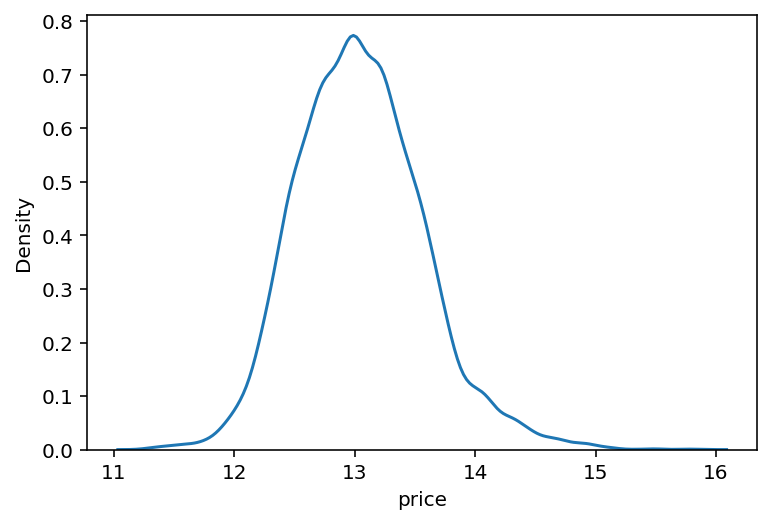

In [15]:
# y data 에 log 를 취해 분포도를 조정
y = np.log1p(y)

# log 를 취한 y data 분포 확인
sns.kdeplot(y)
plt.show()

- np.log1p() 를 취하여 값의 분포가 비교적 완만한 정규분포로 바뀌었음을 확인할 수 있습니다.

In [16]:
# 전체 데이터의 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

- 모든 컬럼이 int 혹은 float 이므로, 모델을 학습시킬 수 있게 되었습니다.

***

### 하이퍼 파라미터 및 모델링

In [61]:
# Model 선언
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [18]:
# Hyper-Parameter
param_grid = {'n_estimators': [50, 100],
              'max_depth': [1, 10]}

- Grid Search 를 통해 최적의 Hyper-Parameter 를 찾아보겠습니다.
- Grid Search 를 위한 Hyper-Parameter 값의 범위를 지정해줍니다.

In [19]:
# LightGBM(lgbm) Model 준비
model = LGBMRegressor(random_state=2019)

- 모델은 LGBMRegressor 를 사용하도록 하겠습니다.

In [20]:
# Model_name
model_name = model.__class__.__name__
model_name

'LGBMRegressor'

- 모델 이름을 변수에 저장합니다.

In [21]:
# Grid Searching
grid_model = GridSearchCV(model, param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5, verbose=1, n_jobs=5)

# Finding Hyper-Parameters
grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2019), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

- GridSearchCV 에 앞서 정의해준 LGBMRegressor 와 param_grid 를 넣어 모델을 생성해주었습니다.
- scoring 은 neg_mean_squared_error 를 사용하며, cross-validation 은 5 로 선언해주었습니다.
- 앞서 정의한 param_grid 에서 알 수 있듯이, 가능한 조합의 개수는 4 개 입니다.
- cross-validation 이 5 이므로, 각 조합마다 5 번의 작업을 수행하게 되며, 총 20 번의 fitting 을 진행하게 됩니다.

In [22]:
# Results
grid_model.cv_results_

{'mean_fit_time': array([0.19064713, 0.18215189, 0.32511339, 0.48636575]),
 'std_fit_time': array([0.06259321, 0.00419789, 0.01073406, 0.07424879]),
 'mean_score_time': array([0.00707626, 0.01012659, 0.02542863, 0.02787504]),
 'std_score_time': array([0.00024992, 0.00034814, 0.0104042 , 0.00239375]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

- Grid Search 의 결과를 출력합니다.

In [23]:
# Summary
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

print("params: {}".format(params))
print("score: {}".format(score))

params: [{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
score: [-0.07339447 -0.05502043 -0.02917734 -0.02702714]


- 위 결과에서 중요한 지표는 'max_depth' 와 'n_estimators', 'score' 입니다.

In [24]:
# 각 조합별 점수 dataframe
df_results = pd.DataFrame(params)
df_results['score'] = score

df_results

max_depth  n_estimators     score
0          1            50 -0.073394
1          1           100 -0.055020
2         10            50 -0.029177
3         10           100 -0.027027

- 결과를 직관적으로 확인하기 위해 DataFrame 으로 표현해주었습니다.

In [25]:
# RMSLE 를 추가한 dataframe
df_results['RMSLE'] = np.sqrt(-1 * df_results['score'])
df_results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

- log 를 취한 y 값에 대해 exp 로 복원하지 않고 오차를 계산하였으므로 RMSLE 가 될 것입니다.

In [26]:
# RMSLE 오름차순 정렬
df_results = df_results.sort_values(by=['RMSLE'])
df_results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

In [62]:
# 위의 과정들을 함수로 정의
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # grid_search_model 생성
    grid_model = GridSearchCV(model, param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # model fitting
    grid_model.fit(train, y)
    
    # model 결과값을 dataframe 으로 생성
    df_results = pd.DataFrame(grid_model.cv_results_['params'])
    df_results['score'] = grid_model.cv_results_['mean_test_score']
    
    # RMSLE 생성 후 정렬
    df_results['RMSLE'] = np.sqrt(-1 * df_results['score'])
    df_results = df_results.sort_values(by='RMSLE')
    
    return df_results

- 모델과 파라미터 범위를 인자로 받아 Grid Search 를 자동화하여 결과를 DataFrame 으로 반환하는 함수를 정의하였습니다.

In [28]:
# Grid Searching
param_grid = {'n_estimators': [50, 100],
              'max_depth': [1, 10]}

model = LGBMRegressor(random_state=2019)
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

***

### Test data 학습 및 예측

In [29]:
# 찾아낸 Hyper-Parameter 를 적용하여 학습 후 예측
model = LGBMRegressor(max_depth=10, n_estimators=100, 
                      random_state=2019)

model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

- 앞서 찾아낸 최적의 Hyper-Parameter 를 적용하여 LGBMRegressor 모델을 생성하였습니다.
- 모델을 학습시킨 후, test 데이터에 대한 예측을 수행합니다.

In [30]:
# 예측값을 exp 로 변환
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

- prediction 에 np.expm1 을 취해 변환해주면, 저희가 찾고자 하는 예측값을 도출할 수 있습니다.

***

### 예측한 결과를 csv 파일로 저장

In [31]:
# sample_submission.csv
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

- sample_submission.csv 파일을 불러옵니다.

In [32]:
# prediction 을 sample_submission 의 'price' 컬럼에 덮어씌우기
submission['price'] = prediction
submission.head()

id         price
0  15035  5.067667e+05
1  15036  4.795061e+05
2  15037  1.345155e+06
3  15038  3.122579e+05
4  15039  3.338645e+05

- sample_submission.csv 의 price 컬럼에 앞서 예측한 prediction 을 붙여넣습니다.

In [33]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, 0.164399)
submission.to_csv(submission_csv_path, index=False)
    
print('{} saved!'.format(submission_csv_path))

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMRegressor_RMSLE_0.164399.csv saved!


In [76]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print('{} saved!'.format(submission_csv_path))

- 모델과 데이터, 모델이름과 RMSLE 를 인자로 받아 모델 학습 및 예측 후, 결과를 csv 파일로 저장하는 과정을 자동화하는 함수입니다.

# 1.2) Source Code - Ensemble

### 데이터 준비

In [35]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [36]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [37]:
test.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

In [38]:
print("train.shape:", train.shape)
print("test.shape:", test.shape)

train.shape: (15035, 21)
test.shape: (6468, 20)


***

### 데이터 전처리

In [39]:
del train['id']
del test['id']

# Test
print("train.shape:", train.shape)
print("test.shape:", test.shape)

train.shape: (15035, 20)
test.shape: (6468, 19)


- 1.1) 과 동일하게 id 컬럼을 삭제해주겠습니다.

In [40]:
y = train['price']
del train['price']

# Test
print("train.shape:", train.shape)
print("y.shape:", y.shape)

train.shape: (15035, 19)
y.shape: (15035,)


- target 값을 y 변수에 따로 저장해두고 train 에서는 삭제해주었습니다.

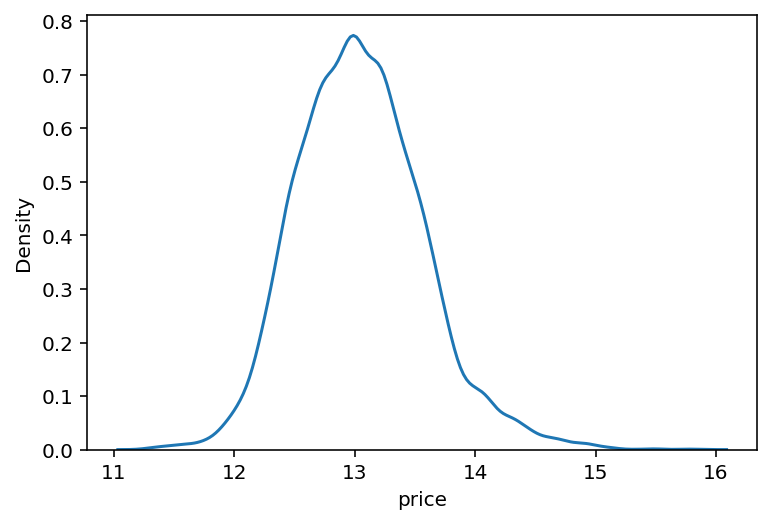

In [41]:
y = np.log1p(y)

# Visualization
sns.kdeplot(y)
plt.show()

- 1.1) 과 동일하게 price 값의 정규성을 log 를 취해 조정해주었습니다.

In [42]:
train['date'] = train['date'].apply(lambda x: x[:8]).astype(int)
test['date'] = test['date'].apply(lambda x: x[:8]).astype(int)

In [43]:
# Test
train.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141013         3       1.00         1180      5650     1.0           0   
1  20150225         2       1.00          770     10000     1.0           0   
2  20150218         3       2.00         1680      8080     1.0           0   
3  20140627         3       2.25         1715      6819     2.0           0   
4  20150115         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

In [44]:
# Test
test.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141209         3       2.25         2570      7242     2.0           0   
1  20141209         4       3.00         1960      5000     1.0           0   
2  20140512         4       4.50         5420    101930     1.0           0   
3  20150415         3       1.00         1780      7470     1.0           0   
4  20150312         3       2.50         1890      6560     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        2170            400      1951          1991   
1     0          5      7        1050            910      1965             0   
2     0          3     11        3890           1530      2001             0   
3     0          3      7        1050            730      1960             0   
4     0          3      7        1890              0      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98125  47.7210 -122.319           1690        7639  
1    98136  47.5208 -122.393           1360        5000  
2    98053  47.6561 -122.005           4760      101930  
3    98146  47.5123 -122.337           1780        8113  
4    98038  47.3684 -122.031           2390        7570

- 날짜값을 연/월/일 까지 사용하기 위해 변환해주었습니다.

In [45]:
data = pd.concat((train, test), axis=0)

# Test
data.shape

(21503, 19)

- 각 컬럼의 분포를 측정하기 위해 train 과 test 를 data 라는 변수에 합하였습니다.

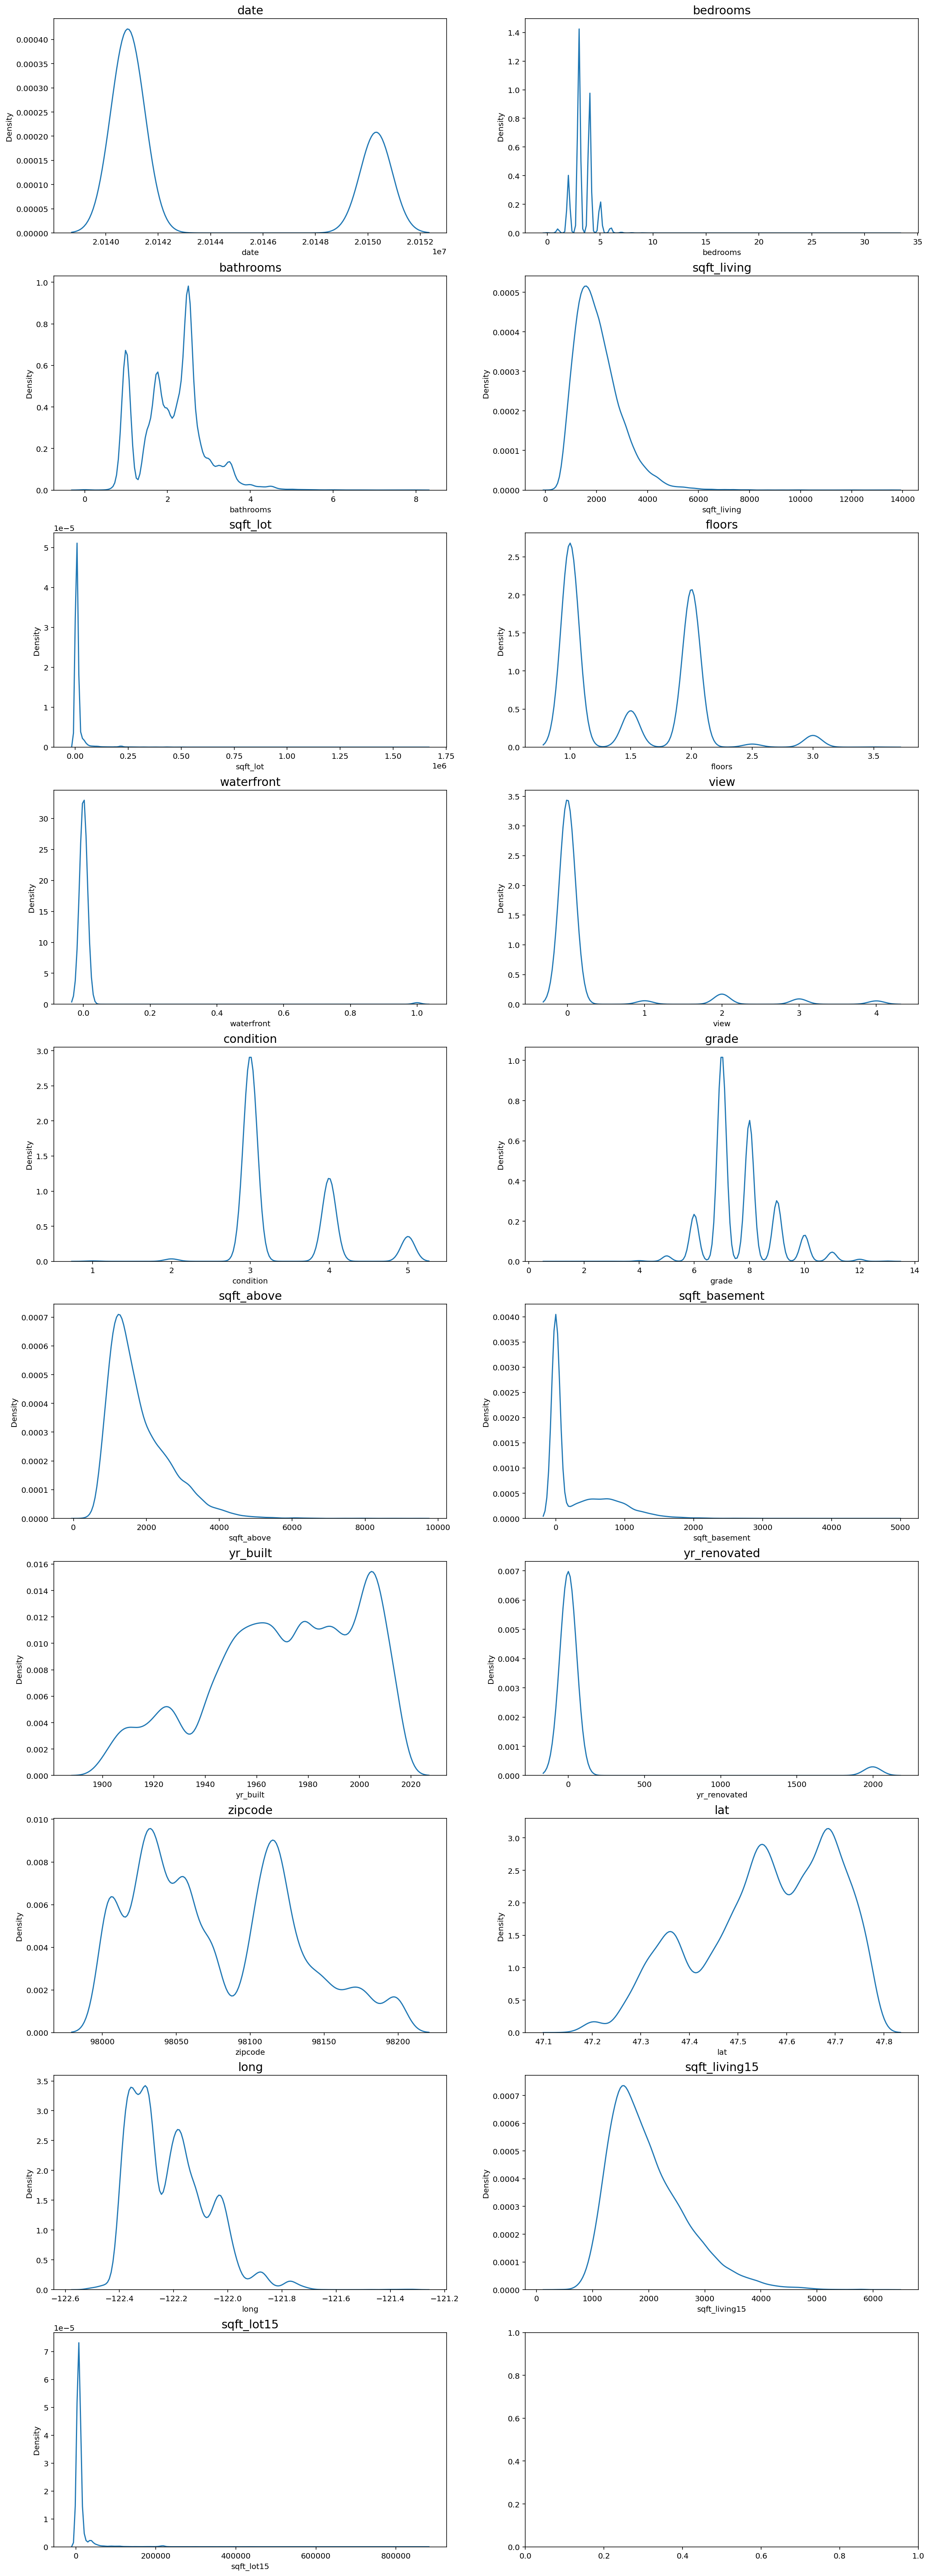

In [46]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

- data 의 각 컬럼값의 분포입니다.
- bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보이고 있으므로, log_scaling 을 통해 정규화합니다.

In [47]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot','sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

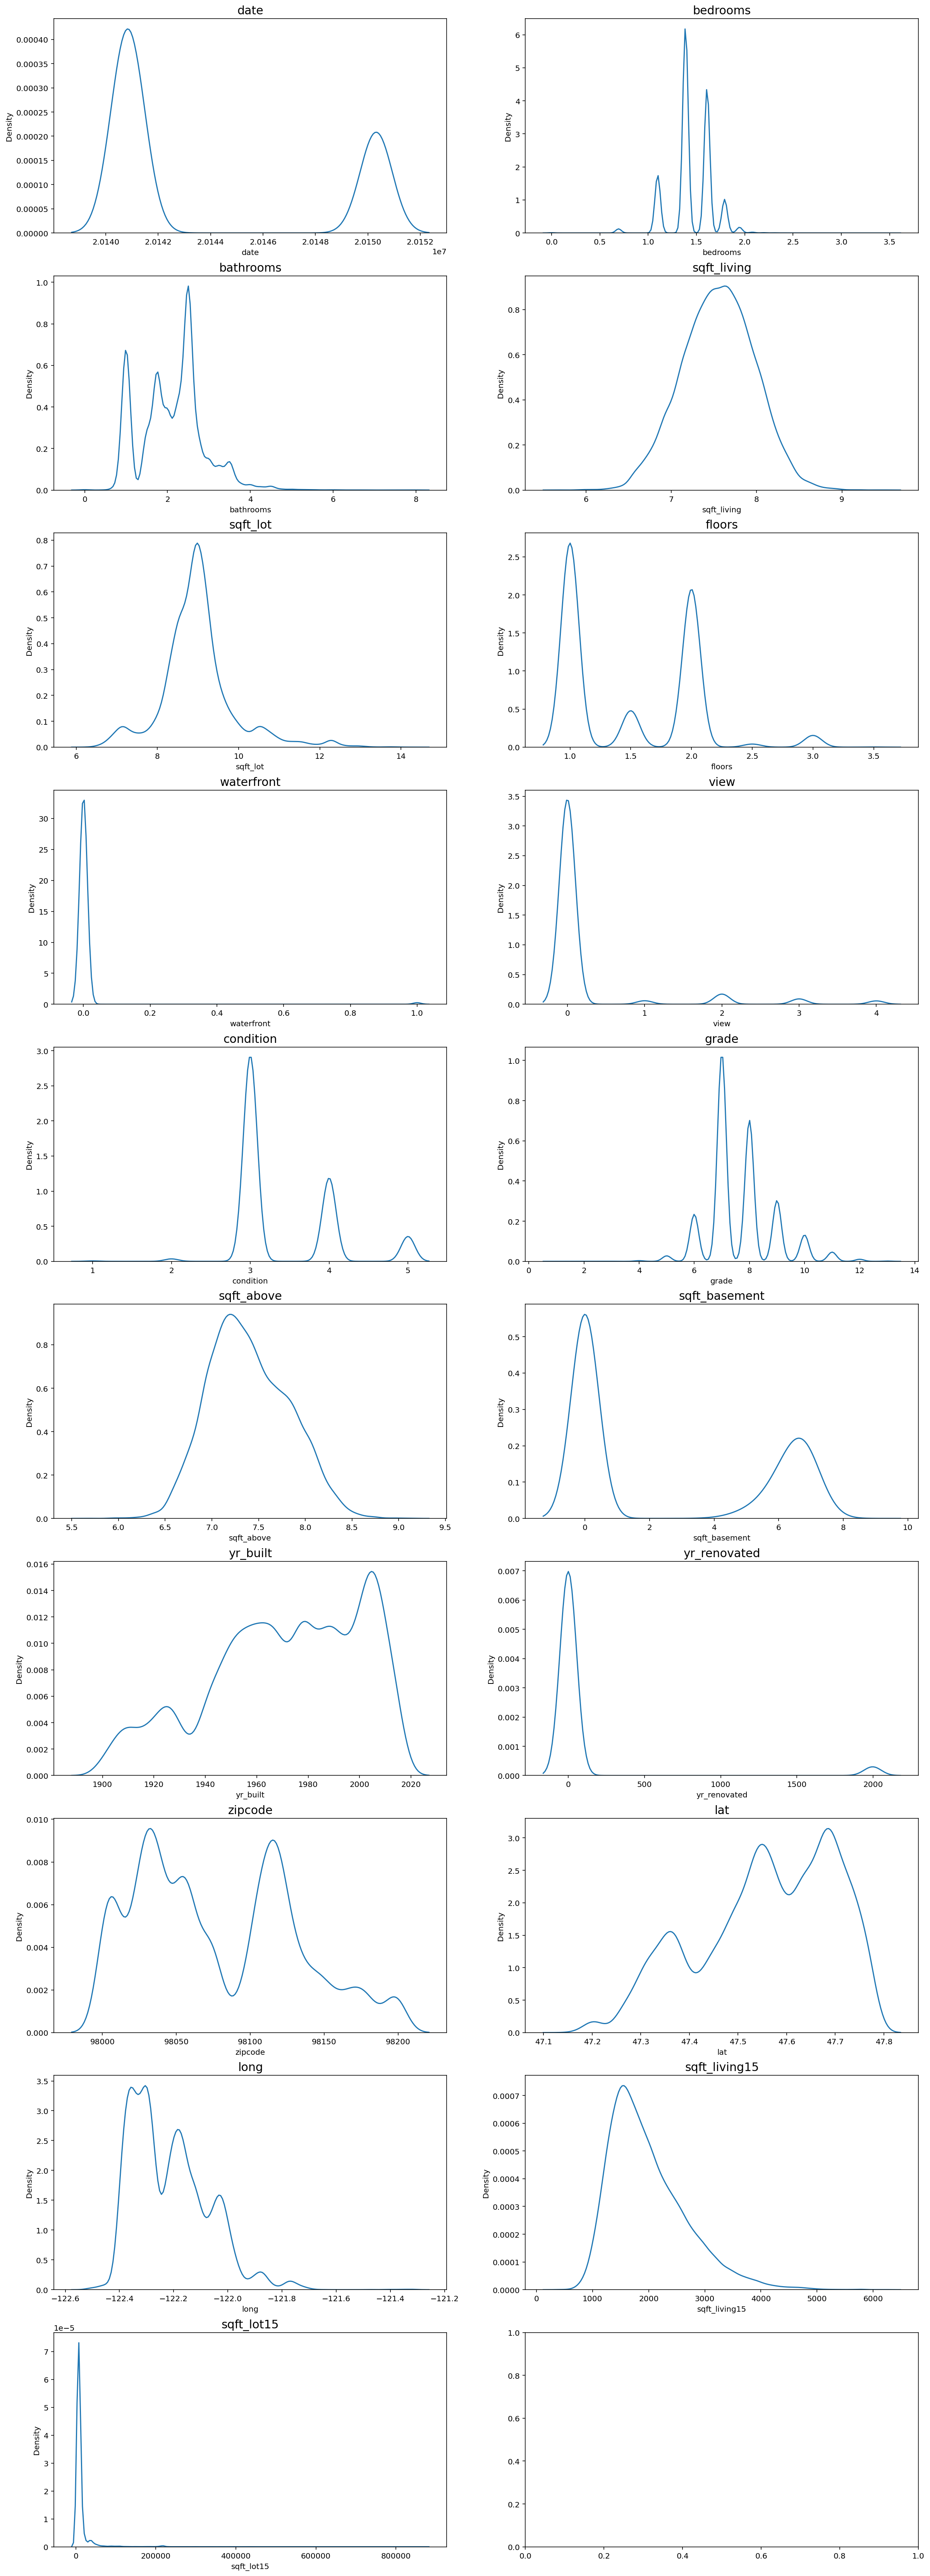

In [48]:
# Test
data = pd.concat((train, test), axis=0)

fig, ax = plt.subplots(10, 2, figsize=(20, 60))

count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

- 한쪽으로 치우쳐있었던 컬럼들의 값 분포가 비교적 정규성을 띄고 있습니다.

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

- 모든 컬럼값이 int 혹은 float type 이므로 학습에 사용할 수 있습니다.

***

### 모델링

In [50]:
# Model 선언
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
random_state=2019

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

- 각 모델을 선언하고, random-seed 값을 설정해주었습니다.
- 이렇게 선언된 모델들을 List 에 담아주었습니다.

In [52]:
# RMSE 함수
# log 를 취해준 y data 를 exp 로 다시 변환
def rmse(y_val, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))

- 앞서 우리는 특정 컬럼 데이터에 log 를 취해주었습니다.
- 따라서, validation 데이터와 예측값에 np.expm1() 을 취해주어 원래값으로 복원시켜주어야 합니다.
- 여기서는, np.expm1() 으로 변환한 후, 실제값과 예측값 간 RMSE 를 반환하는 함수를 정의해주었습니다.

In [53]:
# Cross Validation 함수
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

- 모델의 성능을 간단히 평가하는 함수입니다.

In [54]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8800
Model: XGBoost, CV score:0.8958
Model: LightGBM, CV score:0.9030


- 모델 별 결정계수 값을 도출합니다.
- 값이 1 에 가까울수록 모델이 잘 학습되었음을 의미합니다.
- 위에서는 3개 모델 모두 준수한 성능을 보여주고 있습니다.

***

### Test data 학습 및 예측

In [55]:
def AveragingBlending(models, train, y, test):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

- 3개 모델을 모두 학습시킨 후, Test 데이터에 대해 예측합니다.
- 각 모델에 대한 예측 결과를 평균내어주는 함수입니다.

In [56]:
prediction = AveragingBlending(models, train, y, test)

# Test
print(len(prediction))
prediction

6468


array([13.18746186, 12.98265445, 14.10961816, ..., 13.02530571,
       12.67871702, 12.98302519])

In [57]:
# 예측값을 exp 로 변환
prediction = np.expm1(prediction)
prediction

array([ 533631.06573225,  434804.65935678, 1341927.28597393, ...,
        453750.83699913,  320845.15420688,  434965.89106809])

- 데이터들에 대해 log를 취해주었으므로, expm1 을 다시 취하여 복원시켜줍니다.

***

### 예측한 결과를 csv 파일로 저장

In [77]:
def save_to_csv(prediction, model_name, rmsle=None):    
    # sample_submission.csv
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)

    # prediction 을 sample_submission 의 'price' 컬럼에 덮어씌우기
    submission['price'] = prediction
    submission.head()

    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)

    print('{} saved!'.format(submission_csv_path))

- 예측결과인 prediction, model_name, rmsle 를 인자로 받아 csv 파일로 저장하는 함수입니다.

In [59]:
model_name = 'Ensemble'

save_to_csv(prediction, model_name)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_Ensemble_RMSLE_None.csv saved!


- 각 모델을 학습시킨 후, RMSE 를 도출하여 DataFrame 으로 반환하는 함수입니다.

# 1.3) Source Code - Ensemble

### 데이터 준비

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [4]:
test.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

### 데이터 전처리

In [5]:
for df in [train, test]:
    df['year'] = pd.to_numeric(df.date.str.slice(0, 4))
    df['month'] = pd.to_numeric(df.date.str.slice(4, 6))
    df.drop(['id', 'date'], axis=1, inplace=True)

- date 컬럼에서 연, 월을 잘라내 각각의 컬럼으로 구분하여 주었습니다.
- 학습에 필요하지 않은 id 컬럼과 date 컬럼은 drop 해주었습니다.

In [6]:
train.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  180000.0         2       1.00          770     10000     1.0           0   
2  510000.0         3       2.00         1680      8080     1.0           0   
3  257500.0         3       2.25         1715      6819     2.0           0   
4  291850.0         3       1.50         1060      9711     1.0           0   

   view  condition  grade  ...  sqft_basement  yr_built  yr_renovated  \
0     0          3      7  ...              0      1955             0   
1     0          3      6  ...              0      1933             0   
2     0          3      8  ...              0      1987             0   
3     0          3      7  ...              0      1995             0   
4     0          3      7  ...              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98178  47.5112 -122.257           1340        5650  2014     10  
1    98028  47.7379 -122.233           2720        8062  2015      2  
2    98074  47.6168 -122.045           1800        7503  2015      2  
3    98003  47.3097 -122.327           2238        6819  2014      6  
4    98198  47.4095 -122.315           1650        9711  2015      1  

[5 rows x 21 columns]

In [7]:
test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       2.25         2570      7242     2.0           0     0   
1         4       3.00         1960      5000     1.0           0     0   
2         4       4.50         5420    101930     1.0           0     0   
3         3       1.00         1780      7470     1.0           0     0   
4         3       2.50         1890      6560     2.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7        2170            400      1951          1991   
1          5      7        1050            910      1965             0   
2          3     11        3890           1530      2001             0   
3          3      7        1050            730      1960             0   
4          3      7        1890              0      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98125  47.7210 -122.319           1690        7639  2014     12  
1    98136  47.5208 -122.393           1360        5000  2014     12  
2    98053  47.6561 -122.005           4760      101930  2014      5  
3    98146  47.5123 -122.337           1780        8113  2015      4  
4    98038  47.3684 -122.031           2390        7570  2015      3

In [8]:
train = train.astype('float32')
test = test.astype('float32')

- 컬럼들의 연산을 위해 float type 으로 바꾸어주었습니다.

In [9]:
train['yr_renovated'].unique()

array([   0., 2002., 1999., 1991., 1978., 2005., 2008., 2003., 1994.,
       1984., 1954., 2014., 2011., 1974., 1983., 2013., 1990., 1957.,
       1977., 1981., 1995., 2000., 1986., 1992., 2004., 2007., 1987.,
       2006., 1985., 1971., 1945., 1979., 1997., 2010., 1969., 1948.,
       2009., 1970., 2015., 1989., 2001., 1968., 2012., 1963., 1993.,
       1962., 1972., 1980., 1998., 1955., 1996., 1950., 1956., 1982.,
       1988., 1940., 1946., 1975., 1964., 1958., 1976., 1973., 1967.,
       1965., 1944.], dtype=float32)

In [10]:
test['yr_renovated'].unique()

array([1991.,    0., 2010., 1992., 2013., 1994., 1984., 2002., 2005.,
       1945., 1990., 1988., 2014., 1978., 1998., 1970., 1989., 2004.,
       2009., 1973., 2001., 1986., 1980., 2000., 1950., 2006., 1987.,
       2011., 2003., 1951., 2008., 1996., 1999., 1985., 1953., 1979.,
       1993., 1981., 1982., 1997., 1969., 1983., 1995., 2007., 1976.,
       1977., 1940., 1958., 1964., 2012., 1975., 1957., 1959., 1960.,
       2015., 1968., 1934., 1965., 1974., 1972., 1946.], dtype=float32)

- 재건축 연도의 값 중 0 으로 표시된 값은 재건축을 하지 않았다는 의미입니다.
- 재건축 연도와 건축 연도를 활용하여 재건축 여부 컬럼을 생성해주겠습니다.

In [11]:
for df in [train, test]:
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x < 0 else 1)
    
train.drop(['yr_renovated'], axis=1, inplace=True)
test.drop(['yr_renovated'], axis=1, inplace=True)

print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


- 재건축이 된 건물이라면 1, 재건축이 되지 않은 건물이라면 0 으로 표현됩니다.

In [12]:
train.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0       3.0       1.00       1180.0    5650.0     1.0         0.0   
1  180000.0       2.0       1.00        770.0   10000.0     1.0         0.0   
2  510000.0       3.0       2.00       1680.0    8080.0     1.0         0.0   
3  257500.0       3.0       2.25       1715.0    6819.0     2.0         0.0   
4  291850.0       3.0       1.50       1060.0    9711.0     1.0         0.0   

   view  condition  grade  ...  sqft_basement  yr_built  zipcode        lat  \
0   0.0        3.0    7.0  ...            0.0    1955.0  98178.0  47.511200   
1   0.0        3.0    6.0  ...            0.0    1933.0  98028.0  47.737900   
2   0.0        3.0    8.0  ...            0.0    1987.0  98074.0  47.616798   
3   0.0        3.0    7.0  ...            0.0    1995.0  98003.0  47.309700   
4   0.0        3.0    7.0  ...            0.0    1963.0  98198.0  47.409500   

         long  sqft_living15  sqft_lot15    year  month  is_renovated  
0 -122.257004         1340.0      5650.0  2014.0   10.0             0  
1 -122.233002         2720.0      8062.0  2015.0    2.0             0  
2 -122.044998         1800.0      7503.0  2015.0    2.0             0  
3 -122.327003         2238.0      6819.0  2014.0    6.0             0  
4 -122.315002         1650.0      9711.0  2015.0    1.0             0  

[5 rows x 21 columns]

In [13]:
test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       3.0       2.25       2570.0    7242.0     2.0         0.0   0.0   
1       4.0       3.00       1960.0    5000.0     1.0         0.0   0.0   
2       4.0       4.50       5420.0  101930.0     1.0         0.0   0.0   
3       3.0       1.00       1780.0    7470.0     1.0         0.0   0.0   
4       3.0       2.50       1890.0    6560.0     2.0         0.0   0.0   

   condition  grade  sqft_above  sqft_basement  yr_built  zipcode        lat  \
0        3.0    7.0      2170.0          400.0    1951.0  98125.0  47.721001   
1        5.0    7.0      1050.0          910.0    1965.0  98136.0  47.520802   
2        3.0   11.0      3890.0         1530.0    2001.0  98053.0  47.656101   
3        3.0    7.0      1050.0          730.0    1960.0  98146.0  47.512299   
4        3.0    7.0      1890.0            0.0    2003.0  98038.0  47.368401   

         long  sqft_living15  sqft_lot15    year  month  is_renovated  
0 -122.319000         1690.0      7639.0  2014.0   12.0             1  
1 -122.392998         1360.0      5000.0  2014.0   12.0             0  
2 -122.004997         4760.0    101930.0  2014.0    5.0             0  
3 -122.336998         1780.0      8113.0  2015.0    4.0             0  
4 -122.030998         2390.0      7570.0  2015.0    3.0             0

In [14]:
for df in [train, test]:
    df['far1'] = df['sqft_living'] / df['sqft_lot']

- 부지 면적 중 주거 공간이 차지하는 비율을 새로운 컬럼으로 생성합니다.

In [15]:
train['is_ba'] = 0
train.loc[train.loc[train.sqft_basement != 0].index, 'is_ba'] = 1
train.loc[train.loc[train.sqft_basement == 0].index, 'is_ba'] = 0

test['is_ba'] = 0
test.loc[test.loc[test.sqft_basement != 0].index, 'is_ba'] = 1
test.loc[test.loc[test.sqft_basement == 0].index, 'is_ba'] = 0

- 지하실의 여부를 표현하는 컬럼을 생성합니다.
- 지하실이 있을 경우 1, 없을 경우 0 으로 표현됩니다.

In [16]:
train.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0       3.0       1.00       1180.0    5650.0     1.0         0.0   
1  180000.0       2.0       1.00        770.0   10000.0     1.0         0.0   
2  510000.0       3.0       2.00       1680.0    8080.0     1.0         0.0   
3  257500.0       3.0       2.25       1715.0    6819.0     2.0         0.0   
4  291850.0       3.0       1.50       1060.0    9711.0     1.0         0.0   

   view  condition  grade  ...  zipcode        lat        long  sqft_living15  \
0   0.0        3.0    7.0  ...  98178.0  47.511200 -122.257004         1340.0   
1   0.0        3.0    6.0  ...  98028.0  47.737900 -122.233002         2720.0   
2   0.0        3.0    8.0  ...  98074.0  47.616798 -122.044998         1800.0   
3   0.0        3.0    7.0  ...  98003.0  47.309700 -122.327003         2238.0   
4   0.0        3.0    7.0  ...  98198.0  47.409500 -122.315002         1650.0   

   sqft_lot15    year  month  is_renovated      far1  is_ba  
0      5650.0  2014.0   10.0             0  0.208850      0  
1      8062.0  2015.0    2.0             0  0.077000      0  
2      7503.0  2015.0    2.0             0  0.207921      0  
3      6819.0  2014.0    6.0             0  0.251503      0  
4      9711.0  2015.0    1.0             0  0.109155      0  

[5 rows x 23 columns]

In [17]:
test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       3.0       2.25       2570.0    7242.0     2.0         0.0   0.0   
1       4.0       3.00       1960.0    5000.0     1.0         0.0   0.0   
2       4.0       4.50       5420.0  101930.0     1.0         0.0   0.0   
3       3.0       1.00       1780.0    7470.0     1.0         0.0   0.0   
4       3.0       2.50       1890.0    6560.0     2.0         0.0   0.0   

   condition  grade  sqft_above  ...  zipcode        lat        long  \
0        3.0    7.0      2170.0  ...  98125.0  47.721001 -122.319000   
1        5.0    7.0      1050.0  ...  98136.0  47.520802 -122.392998   
2        3.0   11.0      3890.0  ...  98053.0  47.656101 -122.004997   
3        3.0    7.0      1050.0  ...  98146.0  47.512299 -122.336998   
4        3.0    7.0      1890.0  ...  98038.0  47.368401 -122.030998   

   sqft_living15  sqft_lot15    year  month  is_renovated      far1  is_ba  
0         1690.0      7639.0  2014.0   12.0             1  0.354874      1  
1         1360.0      5000.0  2014.0   12.0             0  0.392000      1  
2         4760.0    101930.0  2014.0    5.0             0  0.053174      1  
3         1780.0      8113.0  2015.0    4.0             0  0.238286      1  
4         2390.0      7570.0  2015.0    3.0             0  0.288110      0  

[5 rows x 22 columns]

In [18]:
train.drop(['sqft_basement'], axis=1, inplace=True)
test.drop(['sqft_basement'], axis=1, inplace=True)

In [19]:
train['new_grade'] = train['grade'] + train['condition'] + train['view']
test['new_grade'] = test['grade'] + test['condition'] + test['view']

- grade, condition, view 를 더한 새로운 컬럼을 생성해주었습니다.

In [20]:
train.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0       3.0       1.00       1180.0    5650.0     1.0         0.0   
1  180000.0       2.0       1.00        770.0   10000.0     1.0         0.0   
2  510000.0       3.0       2.00       1680.0    8080.0     1.0         0.0   
3  257500.0       3.0       2.25       1715.0    6819.0     2.0         0.0   
4  291850.0       3.0       1.50       1060.0    9711.0     1.0         0.0   

   view  condition  grade  ...        lat        long  sqft_living15  \
0   0.0        3.0    7.0  ...  47.511200 -122.257004         1340.0   
1   0.0        3.0    6.0  ...  47.737900 -122.233002         2720.0   
2   0.0        3.0    8.0  ...  47.616798 -122.044998         1800.0   
3   0.0        3.0    7.0  ...  47.309700 -122.327003         2238.0   
4   0.0        3.0    7.0  ...  47.409500 -122.315002         1650.0   

   sqft_lot15    year  month  is_renovated      far1  is_ba  new_grade  
0      5650.0  2014.0   10.0             0  0.208850      0       10.0  
1      8062.0  2015.0    2.0             0  0.077000      0        9.0  
2      7503.0  2015.0    2.0             0  0.207921      0       11.0  
3      6819.0  2014.0    6.0             0  0.251503      0       10.0  
4      9711.0  2015.0    1.0             0  0.109155      0       10.0  

[5 rows x 23 columns]

In [21]:
test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       3.0       2.25       2570.0    7242.0     2.0         0.0   0.0   
1       4.0       3.00       1960.0    5000.0     1.0         0.0   0.0   
2       4.0       4.50       5420.0  101930.0     1.0         0.0   0.0   
3       3.0       1.00       1780.0    7470.0     1.0         0.0   0.0   
4       3.0       2.50       1890.0    6560.0     2.0         0.0   0.0   

   condition  grade  sqft_above  ...        lat        long  sqft_living15  \
0        3.0    7.0      2170.0  ...  47.721001 -122.319000         1690.0   
1        5.0    7.0      1050.0  ...  47.520802 -122.392998         1360.0   
2        3.0   11.0      3890.0  ...  47.656101 -122.004997         4760.0   
3        3.0    7.0      1050.0  ...  47.512299 -122.336998         1780.0   
4        3.0    7.0      1890.0  ...  47.368401 -122.030998         2390.0   

   sqft_lot15    year  month  is_renovated      far1  is_ba  new_grade  
0      7639.0  2014.0   12.0             1  0.354874      1       10.0  
1      5000.0  2014.0   12.0             0  0.392000      1       12.0  
2    101930.0  2014.0    5.0             0  0.053174      1       14.0  
3      8113.0  2015.0    4.0             0  0.238286      1       10.0  
4      7570.0  2015.0    3.0             0  0.288110      0       10.0  

[5 rows x 22 columns]

In [22]:
y = train['price']
del train['price']

# Test
print('train.shape:', train.shape)
print('test.shape:', test.shape)

train.shape: (15035, 22)
test.shape: (6468, 22)


In [23]:
for df in [train, test]:
    df['far15'] = df['sqft_living15'] / df['sqft_lot15']

- 15년 기준 부지 면적 당 주거 면적 컬럼을 생성합니다.

In [24]:
train.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       3.0       1.00       1180.0    5650.0     1.0         0.0   0.0   
1       2.0       1.00        770.0   10000.0     1.0         0.0   0.0   
2       3.0       2.00       1680.0    8080.0     1.0         0.0   0.0   
3       3.0       2.25       1715.0    6819.0     2.0         0.0   0.0   
4       3.0       1.50       1060.0    9711.0     1.0         0.0   0.0   

   condition  grade  sqft_above  ...        long  sqft_living15  sqft_lot15  \
0        3.0    7.0      1180.0  ... -122.257004         1340.0      5650.0   
1        3.0    6.0       770.0  ... -122.233002         2720.0      8062.0   
2        3.0    8.0      1680.0  ... -122.044998         1800.0      7503.0   
3        3.0    7.0      1715.0  ... -122.327003         2238.0      6819.0   
4        3.0    7.0      1060.0  ... -122.315002         1650.0      9711.0   

     year  month  is_renovated      far1  is_ba  new_grade     far15  
0  2014.0   10.0             0  0.208850      0       10.0  0.237168  
1  2015.0    2.0             0  0.077000      0        9.0  0.337385  
2  2015.0    2.0             0  0.207921      0       11.0  0.239904  
3  2014.0    6.0             0  0.251503      0       10.0  0.328201  
4  2015.0    1.0             0  0.109155      0       10.0  0.169910  

[5 rows x 23 columns]

In [25]:
test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       3.0       2.25       2570.0    7242.0     2.0         0.0   0.0   
1       4.0       3.00       1960.0    5000.0     1.0         0.0   0.0   
2       4.0       4.50       5420.0  101930.0     1.0         0.0   0.0   
3       3.0       1.00       1780.0    7470.0     1.0         0.0   0.0   
4       3.0       2.50       1890.0    6560.0     2.0         0.0   0.0   

   condition  grade  sqft_above  ...        long  sqft_living15  sqft_lot15  \
0        3.0    7.0      2170.0  ... -122.319000         1690.0      7639.0   
1        5.0    7.0      1050.0  ... -122.392998         1360.0      5000.0   
2        3.0   11.0      3890.0  ... -122.004997         4760.0    101930.0   
3        3.0    7.0      1050.0  ... -122.336998         1780.0      8113.0   
4        3.0    7.0      1890.0  ... -122.030998         2390.0      7570.0   

     year  month  is_renovated      far1  is_ba  new_grade     far15  
0  2014.0   12.0             1  0.354874      1       10.0  0.221233  
1  2014.0   12.0             0  0.392000      1       12.0  0.272000  
2  2014.0    5.0             0  0.053174      1       14.0  0.046699  
3  2015.0    4.0             0  0.238286      1       10.0  0.219401  
4  2015.0    3.0             0  0.288110      0       10.0  0.315720  

[5 rows x 23 columns]

In [26]:
train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year',
       'month', 'is_renovated', 'far1', 'is_ba', 'new_grade', 'far15'],
      dtype='object')

In [27]:
test.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year',
       'month', 'is_renovated', 'far1', 'is_ba', 'new_grade', 'far15'],
      dtype='object')

In [28]:
train['bathrooms'].unique()

array([1.  , 2.  , 2.25, 1.5 , 2.5 , 1.75, 3.  , 2.75, 3.25, 4.  , 3.5 ,
       0.75, 4.75, 5.  , 4.25, 4.5 , 3.75, 5.25, 6.  , 1.25, 0.5 , 5.5 ,
       6.75, 5.75, 0.  , 8.  , 7.5 , 7.75, 6.25], dtype=float32)

In [29]:
test['bathrooms'].unique()

array([2.25, 3.  , 4.5 , 1.  , 2.5 , 1.75, 1.5 , 2.75, 3.25, 2.  , 3.5 ,
       0.75, 4.25, 0.  , 1.25, 4.  , 3.75, 4.75, 5.  , 5.5 , 6.  , 5.25,
       6.75, 0.5 , 5.75, 6.25, 6.5 ], dtype=float32)

- bathrooms 의 이상치를 확인합니다.

In [30]:
train['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5], dtype=float32)

In [31]:
test['floors'].unique()

array([2. , 1. , 3. , 1.5, 2.5, 3.5], dtype=float32)

- floors 의 이상치를 확인합니다.

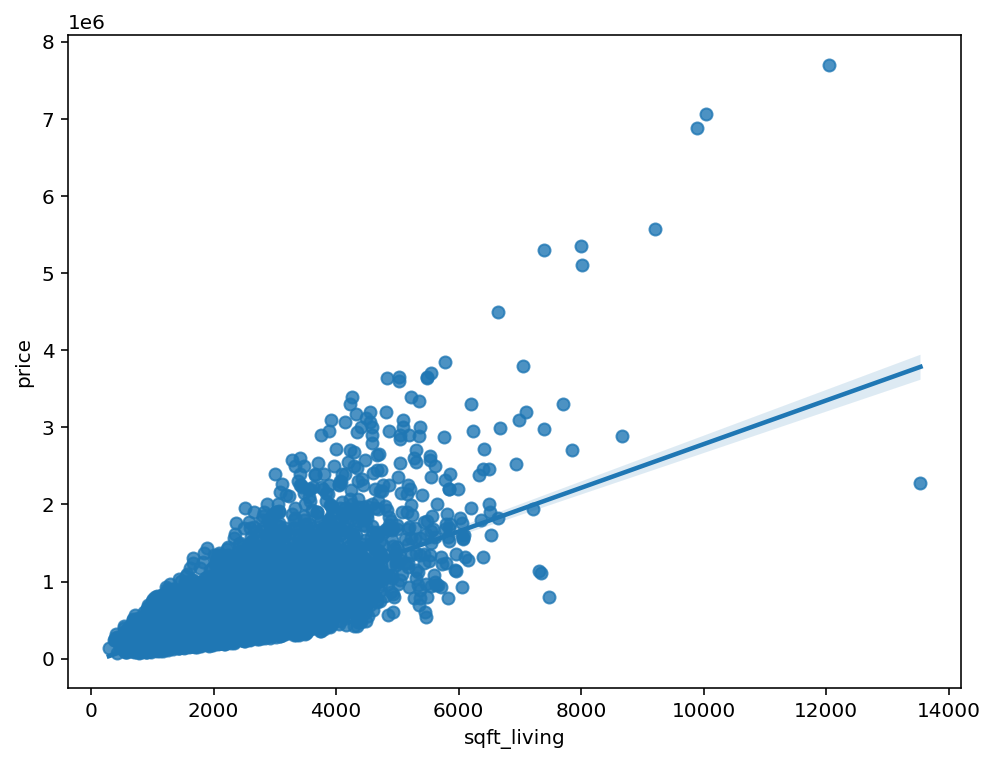

In [32]:
data = pd.concat([y, train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

- seaborn library 의 regplot 을 활용하여 sqft_living 과 price 의 산포도 및 추세선을 그립니다.
- price 에 대해 정규화를 수행한 후 다시 이상치를 확인해보도록 하겠습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

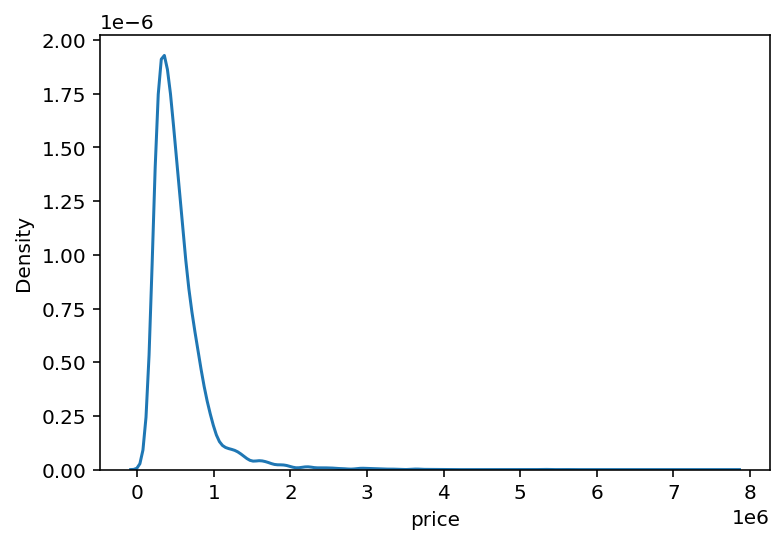

In [33]:
sns.kdeplot(y)

- y 의 분포가 한쪽에 치우져 있으므로, log 를 취해주겠습니다.

In [34]:
y = np.log1p(y)

<AxesSubplot:xlabel='price', ylabel='Density'>

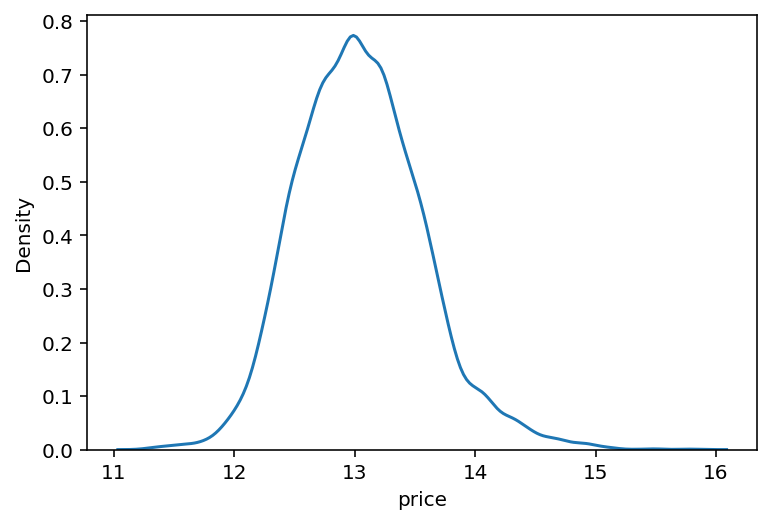

In [35]:
sns.kdeplot(y)

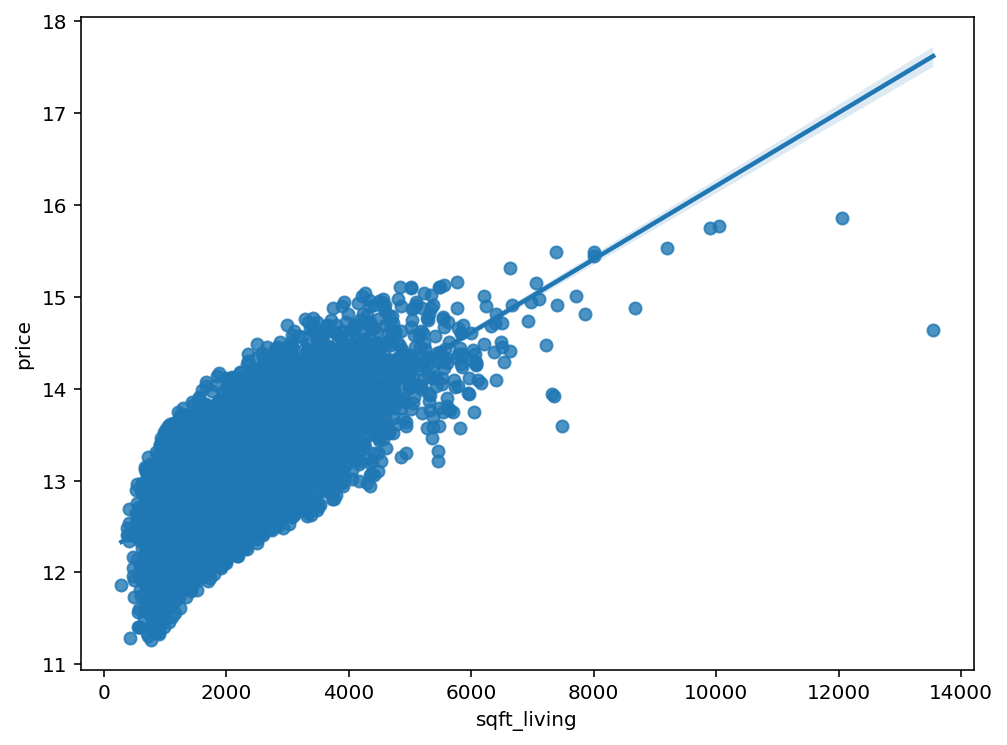

In [36]:
data = pd.concat([y, train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

- sqft_living 13000 이 넘는 구간에 이상치를 제거해주도록 하겠습니다.

In [37]:
data.loc[data['sqft_living'] > 13000]

price  sqft_living
8912  14.639687      13540.0

- 인덱스 8912 인 데이터를 train 과 y 에서 삭제해주어야 합니다.

In [38]:
print(len(train))
print(len(y))

15035
15035


In [39]:
train = train.drop(train.index[8912])
y = y.drop(y.index[8912])

In [40]:
print(len(train))
print(len(y))

15034
15034


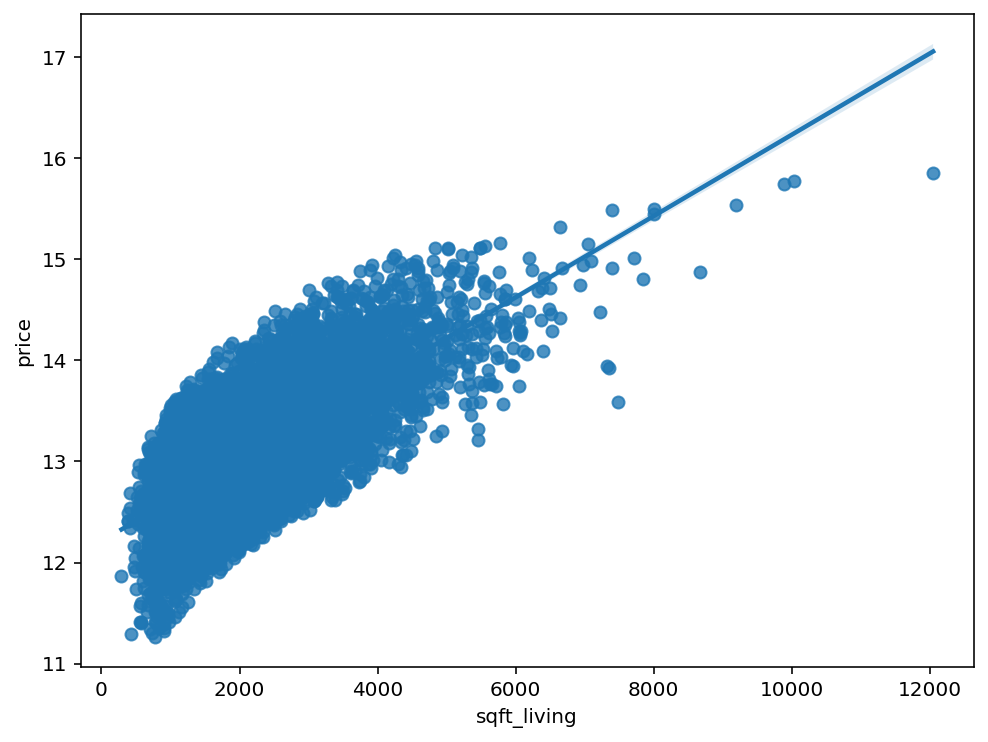

In [41]:
data = pd.concat([y, train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

- 이상치가 제거된 모습을 확인하실 수 있습니다.

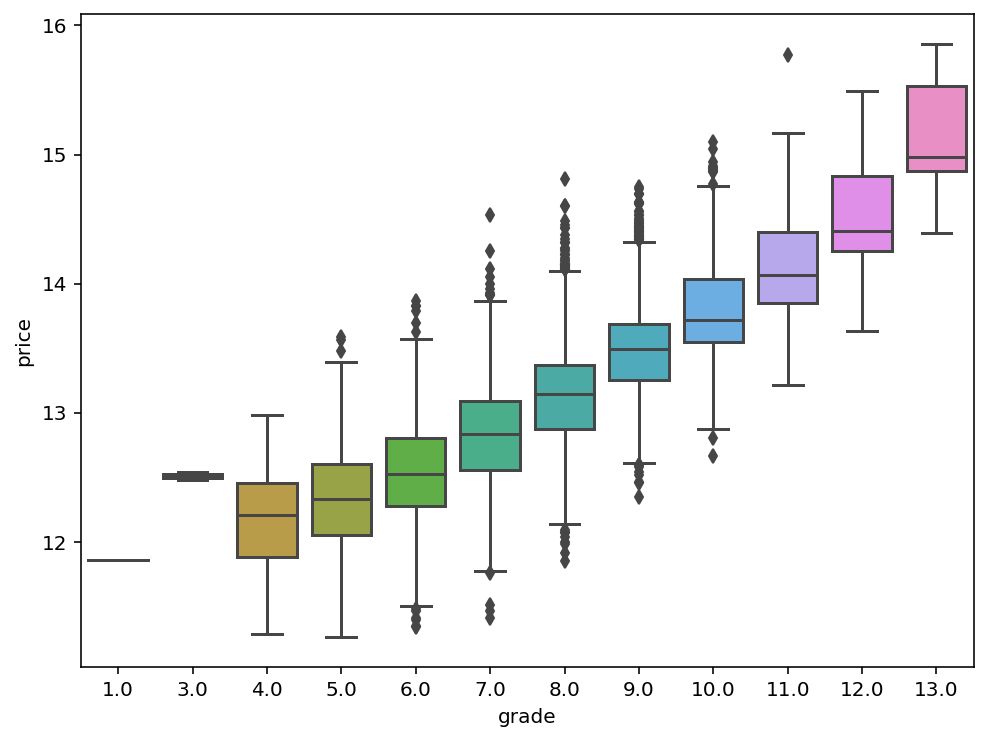

In [42]:
data = pd.concat([y, train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

- grade 와 price 간 관계를 상자그림으로 시각화하였습니다.
- 이 곳에서도 삭제하여야할 이상치가 있습니다.

In [43]:
data.loc[(data['price'] > 12) & (data['grade'] == 3)]

price  grade
2302  12.476104    3.0
4123  12.542548    3.0

In [44]:
data.loc[(data['price'] > 14.7) & (data['grade'] == 8)]

price  grade
7173  14.808763    8.0

In [45]:
data.loc[(data['price'] > 15.5) & (data['grade'] == 11)]

price  grade
2775  15.770309   11.0

In [46]:
print(len(train))
print(len(y))

15034
15034


In [47]:
train = train.drop(train.index[[2302,4123,7173,2775]])
y = y.drop(y.index[[2302,4123,7173,2775]])

- 범위에서 크게 벗어난 4 개의 데이터를 삭제해주었습니다.

In [48]:
print(len(train))
print(len(y))

15030
15030


In [49]:
print(train.shape)
print(test.shape)
print(y.shape)

(15030, 23)
(6468, 23)
(15030,)


In [50]:
data = pd.concat((train, test), axis=0)
data.shape

(21498, 23)

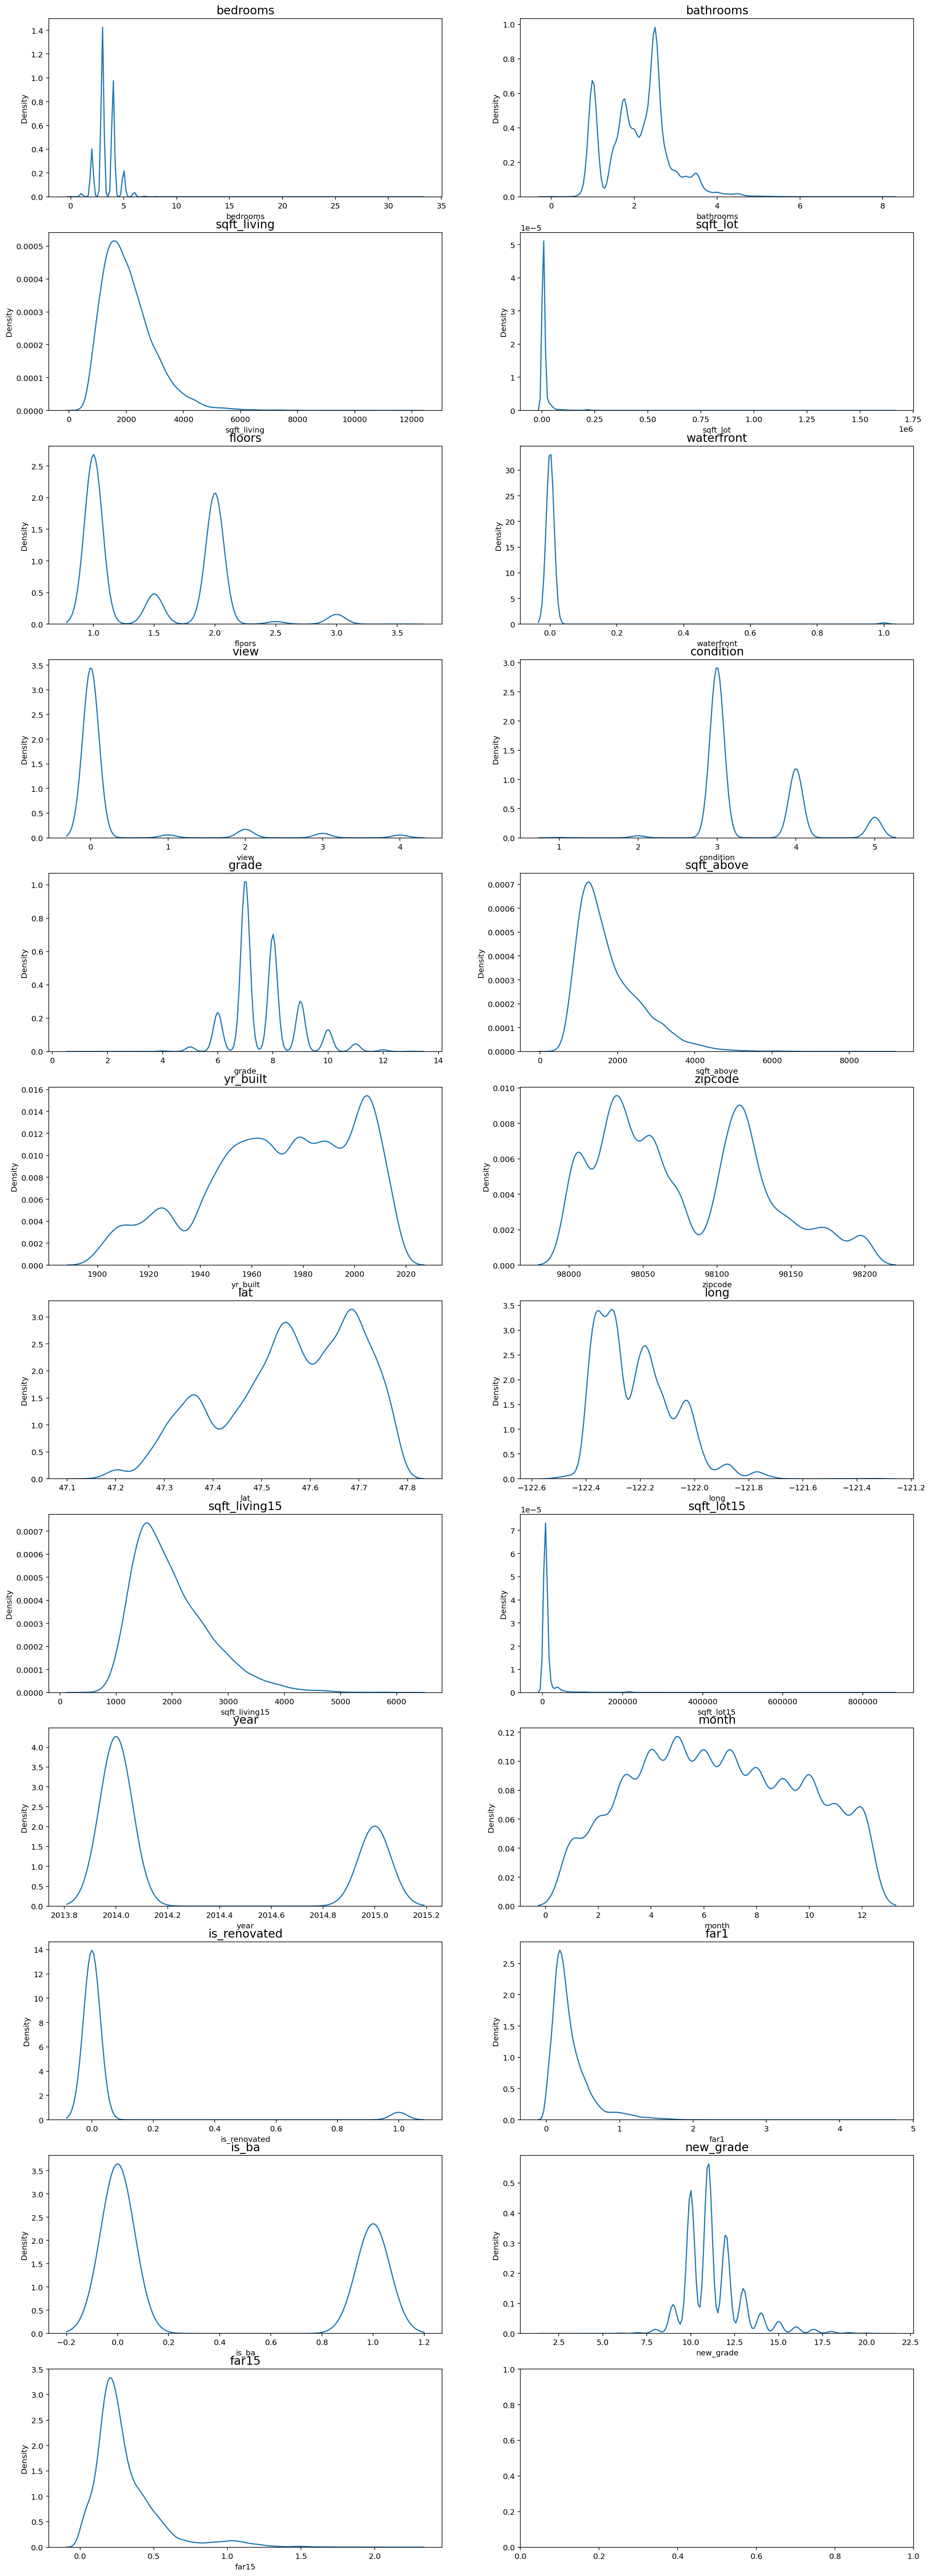

In [51]:
fig, ax = plt.subplots(12, 2, figsize=(20, 60))

count = 0
columns = data.columns
for row in range(12):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 23:
            break

- bedrooms, sqft_living, sqft_lot, sqft_above, sqft_living15, sqft_lot15, far1, far15 의 데이터가 한쪽으로 치우친 경향을 보이고 있습니다.

In [52]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot','sqft_above', 'sqft_living15', 'sqft_lot15','far1', 'far15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

In [53]:
data = pd.concat((train, test), axis=0)
data.shape

(21498, 23)

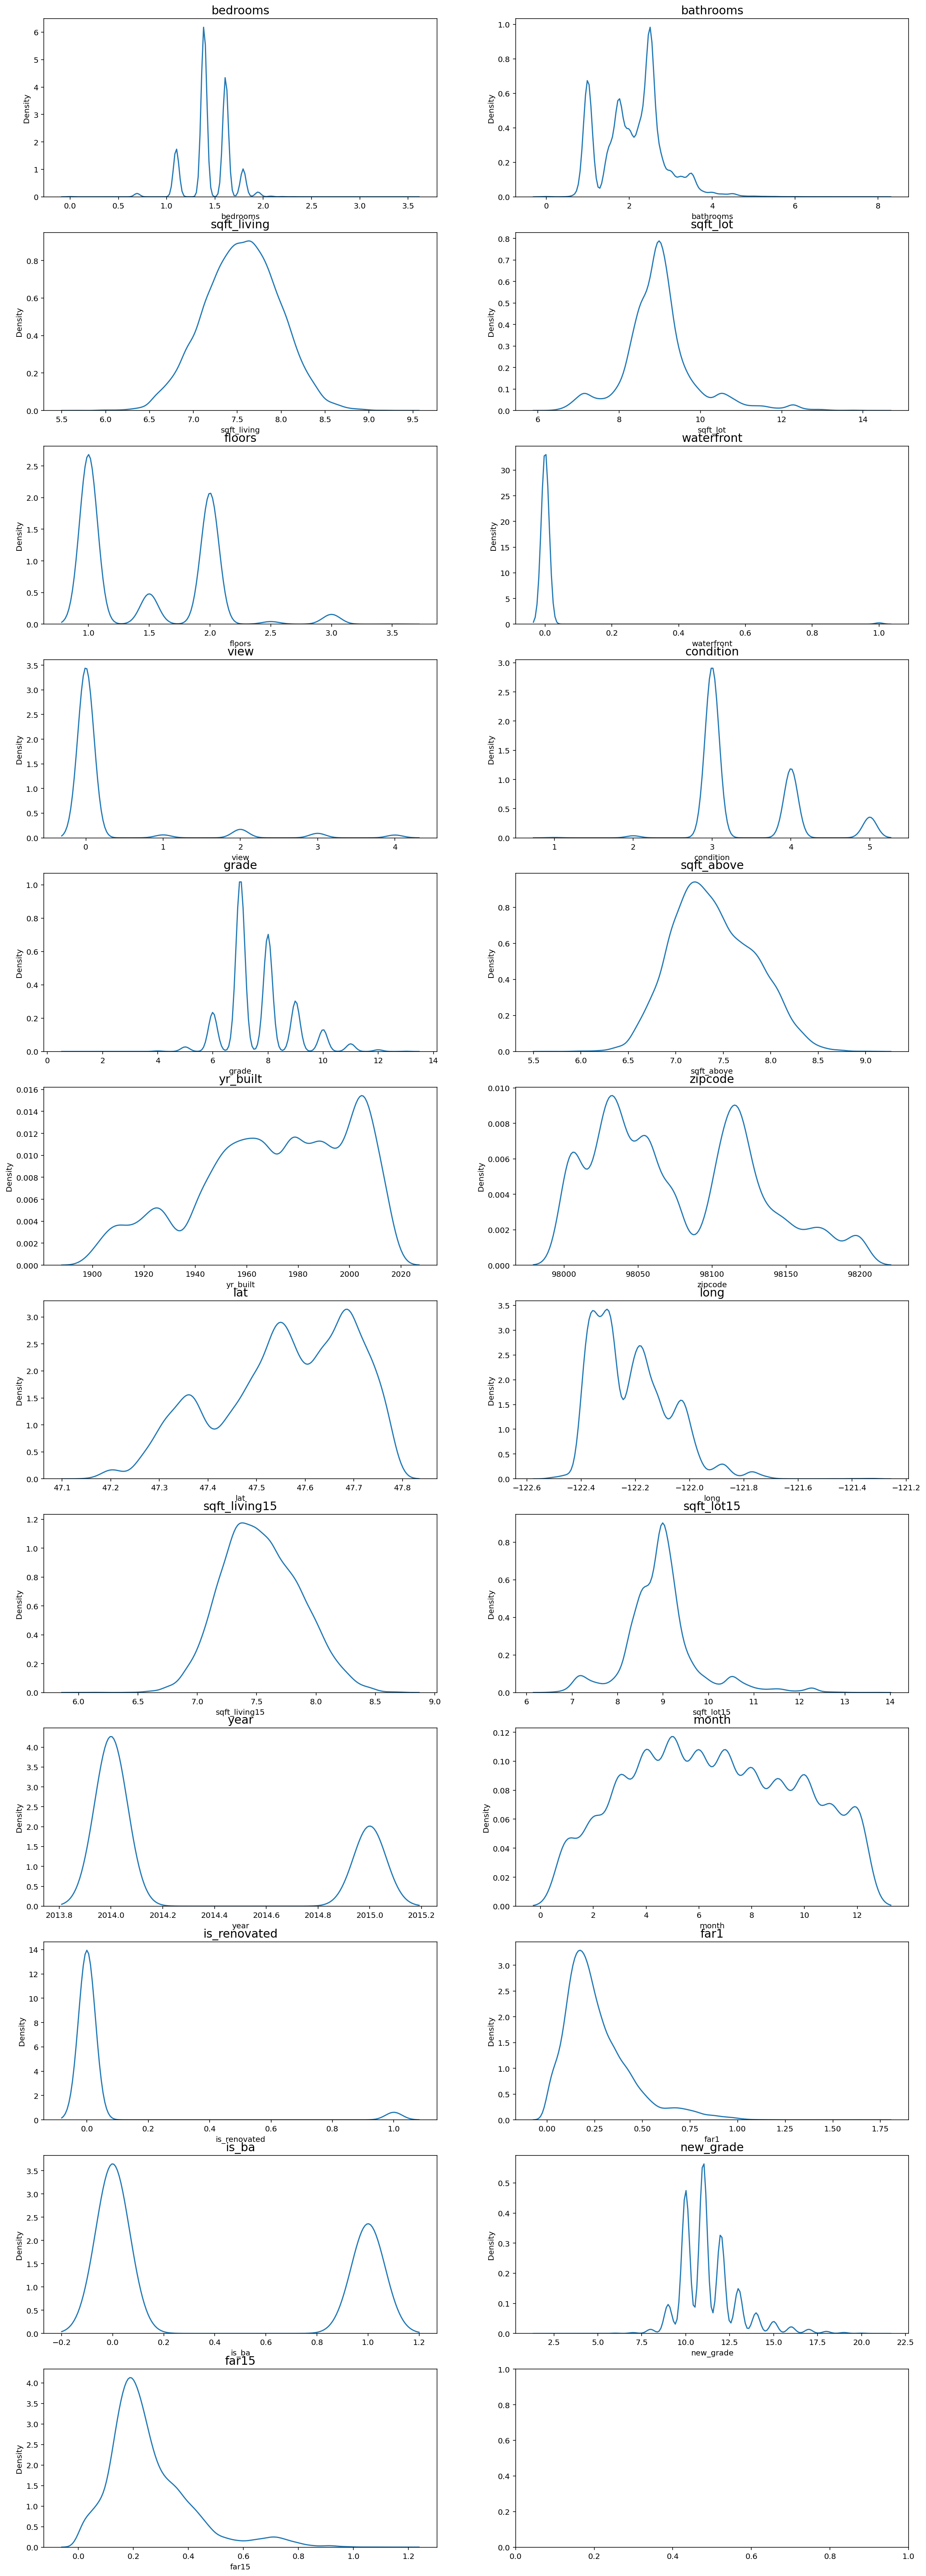

In [112]:
fig, ax = plt.subplots(12, 2, figsize=(20, 60))

count = 0
columns = data.columns
for row in range(12):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 23:
            break

- 각 컬럼들의 분포도가 비교적 완만해진 모습을 확인하실 수 있습니다.

In [54]:
for df in [train, test]:
    df['sqft_total_size15'] = df['sqft_living15'] + df['sqft_lot15']

- 15년도 기준 부지면적의 총합 컬럼을 생성해주었습니다.

In [55]:
print(train.shape)
print(test.shape)

(15030, 24)
(6468, 24)


In [56]:
train.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0  1.386294       1.00     7.074117  8.639587     1.0         0.0   0.0   
1  1.098612       1.00     6.647688  9.210441     1.0         0.0   0.0   
2  1.386294       2.00     7.427144  8.997271     1.0         0.0   0.0   
3  1.386294       2.25     7.447751  8.827615     2.0         0.0   0.0   
4  1.386294       1.50     6.966967  9.181117     1.0         0.0   0.0   

   condition  grade  sqft_above  ...  sqft_living15  sqft_lot15    year  \
0        3.0    7.0    7.074117  ...       7.201171    8.639587  2014.0   
1        3.0    6.0    6.647688  ...       7.908755    8.995041  2015.0   
2        3.0    8.0    7.427144  ...       7.496098    8.923191  2015.0   
3        3.0    7.0    7.447751  ...       7.713785    8.827615  2014.0   
4        3.0    7.0    6.966967  ...       7.409136    9.181117  2015.0   

   month  is_renovated      far1  is_ba  new_grade     far15  \
0   10.0             0  0.189669      0       10.0  0.212825   
1    2.0             0  0.074179      0        9.0  0.290716   
2    2.0             0  0.188901      0       11.0  0.215034   
3    6.0             0  0.224345      0       10.0  0.283825   
4    1.0             0  0.103598      0       10.0  0.156927   

   sqft_total_size15  
0          15.840758  
1          16.903795  
2          16.419289  
3          16.541399  
4          16.590254  

[5 rows x 24 columns]

In [57]:
test.head()

bedrooms  bathrooms  sqft_living   sqft_lot  floors  waterfront  view  \
0  1.386294       2.25     7.852050   8.887791     2.0         0.0   0.0   
1  1.609438       3.00     7.581210   8.517393     1.0         0.0   0.0   
2  1.609438       4.50     8.598036  11.532051     1.0         0.0   0.0   
3  1.386294       1.00     7.484930   8.918784     1.0         0.0   0.0   
4  1.386294       2.50     7.544861   8.788898     2.0         0.0   0.0   

   condition  grade  sqft_above  ...  sqft_living15  sqft_lot15    year  \
0        3.0    7.0    7.682943  ...       7.433075    8.941153  2014.0   
1        5.0    7.0    6.957498  ...       7.215975    8.517393  2014.0   
2        3.0   11.0    8.266421  ...       8.468213   11.532051  2014.0   
3        3.0    7.0    6.957498  ...       7.484930    9.001347  2015.0   
4        3.0    7.0    7.544861  ...       7.779467    8.932080  2015.0   

   month  is_renovated      far1  is_ba  new_grade     far15  \
0   12.0             1  0.303709      1       10.0  0.199861   
1   12.0             0  0.330742      1       12.0  0.240590   
2    5.0             0  0.051808      1       14.0  0.045641   
3    4.0             0  0.213729      1       10.0  0.198360   
4    3.0             0  0.253176      0       10.0  0.274384   

   sqft_total_size15  
0          16.374228  
1          15.733368  
2          20.000263  
3          16.486277  
4          16.711548  

[5 rows x 24 columns]

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15030 entries, 0 to 15034
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           15030 non-null  float32
 1   bathrooms          15030 non-null  float32
 2   sqft_living        15030 non-null  float32
 3   sqft_lot           15030 non-null  float32
 4   floors             15030 non-null  float32
 5   waterfront         15030 non-null  float32
 6   view               15030 non-null  float32
 7   condition          15030 non-null  float32
 8   grade              15030 non-null  float32
 9   sqft_above         15030 non-null  float32
 10  yr_built           15030 non-null  float32
 11  zipcode            15030 non-null  float32
 12  lat                15030 non-null  float32
 13  long               15030 non-null  float32
 14  sqft_living15      15030 non-null  float32
 15  sqft_lot15         15030 non-null  float32
 16  year               150

In [59]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           6468 non-null   float32
 1   bathrooms          6468 non-null   float32
 2   sqft_living        6468 non-null   float32
 3   sqft_lot           6468 non-null   float32
 4   floors             6468 non-null   float32
 5   waterfront         6468 non-null   float32
 6   view               6468 non-null   float32
 7   condition          6468 non-null   float32
 8   grade              6468 non-null   float32
 9   sqft_above         6468 non-null   float32
 10  yr_built           6468 non-null   float32
 11  zipcode            6468 non-null   float32
 12  lat                6468 non-null   float32
 13  long               6468 non-null   float32
 14  sqft_living15      6468 non-null   float32
 15  sqft_lot15         6468 non-null   float32
 16  year               6468 

***

### 모델링

In [119]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [120]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8783
Model: XGBoost, CV score:0.8954
Model: LightGBM, CV score:0.9016


***

### Test data 학습 및 예측

In [121]:
prediction = AveragingBlending(models, train, y, test)

# Test
print(len(prediction))
prediction

6468


array([13.2423484 , 13.1206595 , 14.12111565, ..., 13.03179576,
       12.68682536, 12.98575298])

In [122]:
prediction = np.expm1(prediction)
prediction

array([ 563738.98477182,  499147.78462263, 1357445.13158752, ...,
        456705.2846129 ,  323457.26213434,  436154.00825328])

***

### 예측한 결과를 csv 파일로 저장

In [123]:
model_name = 'Ensemble2'

save_to_csv(prediction, model_name)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_Ensemble2_RMSLE_None.csv saved!


***

# 1.4) Source Code - LGBMRegressor

- 1.3) 과 동일한 전처리 과정을 거친 데이터를 사용하겠습니다.

### 하이퍼 파라미터 및 모델링

In [150]:
print(train.shape)
print(test.shape)
print(y.shape)

(15030, 24)
(6468, 24)
(15030,)


In [151]:
model = LGBMRegressor(random_state=2021)

In [152]:
# Model_name
model_name = model.__class__.__name__
model_name

'LGBMRegressor'

In [153]:
# Grid Searching
param_grid = {'n_estimators': [250, 300, 350, 400, 450],
              'max_depth': [30, 40, 50, 60]}

my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


max_depth  n_estimators     score     RMSLE
2          30           350 -0.026459  0.162662
17         60           350 -0.026459  0.162662
7          40           350 -0.026459  0.162662
12         50           350 -0.026459  0.162662
1          30           300 -0.026480  0.162727
6          40           300 -0.026480  0.162727
11         50           300 -0.026480  0.162727
16         60           300 -0.026480  0.162727
3          30           400 -0.026489  0.162754
8          40           400 -0.026489  0.162754
18         60           400 -0.026489  0.162754
13         50           400 -0.026489  0.162754
0          30           250 -0.026508  0.162814
5          40           250 -0.026508  0.162814
10         50           250 -0.026508  0.162814
15         60           250 -0.026508  0.162814
9          40           450 -0.026542  0.162917
4          30           450 -0.026542  0.162917
14         50           450 -0.026542  0.162917
19         60           450 -0.026542  0.162917

- 최적의 하이퍼 파라미터는 max_depth 는 30, n_estimators 는 350 으로 도출되었습니다.

### Test data 학습 및 예측

In [154]:
model = LGBMRegressor(max_depth=30, n_estimators=350, 
                      random_state=2021)

model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.20233606, 13.17362092, 14.08066015, ..., 13.05855579,
       12.660783  , 13.01529417])

In [155]:
prediction = np.expm1(prediction)
prediction

array([ 541627.74043308,  526295.97234859, 1303624.96761198, ...,
        469091.74920557,  315142.38301235,  449230.74439451])

### 예측한 결과를 csv 파일로 저장

In [157]:
save_to_csv(prediction, model_name, 0.162662)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMRegressor_RMSLE_0.162662.csv saved!


***

# 1.5) Source Code - XGBRegressor

- 1.3) 과 동일한 전처리 과정을 거친 데이터를 사용하겠습니다.

### 하이퍼 파라미터 및 모델링

In [168]:
print(train.shape)
print(test.shape)
print(y.shape)

(15030, 24)
(6468, 24)
(15030,)


In [174]:
dmatrix = xgb.DMatrix(data=train, label=y)

params={'objective':'reg:squarederror',
        'max_depth': 6, 
        'colsample_bylevel':0.5,
        'learning_rate':0.01,
        'random_state':20}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20, num_boost_round=1000)
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 0.16


In [186]:
model = xgb.train(params=params, dtrain=dmatrix, num_boost_round=1000)

### Test data 학습 및 예측

In [187]:
dtest = xgb.DMatrix(data=test)

In [188]:
prediction = model.predict(dtest)

In [189]:
prediction = np.expm1(prediction)
prediction

array([ 532020.75,  444211.3 , 1364349.8 , ...,  447919.94,  321351.22,
        440950.34], dtype=float32)

### 예측한 결과를 csv 파일로 저장

In [191]:
# Model_name
model_name = 'XGBRegressor'
model_name

'XGBRegressor'

In [183]:
save_to_csv(prediction, model_name)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGBRegressor_RMSLE_None.csv saved!


***

# 1.6) Source Code - LGBMRegressor

- 1.3) 과 동일한 전처리 과정을 거친 데이터를 사용하겠습니다.

### 하이퍼 파라미터 및 모델링

In [79]:
print(train.shape)
print(test.shape)
print(y.shape)

(15030, 24)
(6468, 24)
(15030,)


In [71]:
param_grid = {'n_estimators': [290, 300, 950, 1000, 1050],
              'max_depth': [6, 7, 8, 10, 15]}

model = LGBMRegressor(random_state=2021)
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


max_depth  n_estimators     score     RMSLE
1           6           300 -0.026353  0.162335
0           6           290 -0.026353  0.162337
6           7           300 -0.026449  0.162632
5           7           290 -0.026454  0.162646
11          8           300 -0.026467  0.162688
10          8           290 -0.026473  0.162707
20         15           290 -0.026541  0.162913
21         15           300 -0.026541  0.162914
16         10           300 -0.026563  0.162981
15         10           290 -0.026565  0.162989
2           6           950 -0.026992  0.164292
3           6          1000 -0.027040  0.164440
7           7           950 -0.027049  0.164466
4           6          1050 -0.027071  0.164534
12          8           950 -0.027075  0.164545
8           7          1000 -0.027093  0.164599
13          8          1000 -0.027118  0.164675
14          8          1050 -0.027145  0.164757
9           7          1050 -0.027147  0.164763
17         10           950 -0.027149  0.164769
22         15           950 -0.027164  0.164814
18         10          1000 -0.027198  0.164919
23         15          1000 -0.027226  0.165002
19         10          1050 -0.027261  0.165108
24         15          1050 -0.027278  0.165161

In [80]:
# Model_name
model_name = model.__class__.__name__
model_name

'LGBMRegressor'

### Test data 학습 및 예측

In [81]:
model = LGBMRegressor(max_depth=6, n_estimators=300, 
                      random_state=2021)

model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.22141246, 13.16361403, 14.14355307, ..., 13.0830576 ,
       12.6513201 , 13.05250645])

In [82]:
prediction = np.expm1(prediction)
prediction

array([ 552059.24517698,  521055.64189642, 1388246.98691694, ...,
        480727.33659571,  312174.27930106,  466262.61256742])

### 예측한 결과를 csv 파일로 저장

In [83]:
save_to_csv(prediction, model_name, 0.162335)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMRegressor_RMSLE_0.162335.csv saved!


# 2) Retrospection